## Test model predictions

In [1]:
from molmass import Formula

from reframed import pFBA, Environment, FVA, FBA, load_cbmodel, save_cbmodel,plot_flux_envelope, gene_knockout, ReactionType
from cobra.io import read_sbml_model,save_json_model
from collections import OrderedDict
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from collections import OrderedDict
import numpy as np

import sys
sys.path.append("../functions/")
import EGC
from mini_model_function import build_mini_model

#### Loading model

In [2]:
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')

model_iFS431 = load_cbmodel("../models/other_models/iFS431_genes.xml",flavor="cobra",exchange_detection="^EX_.*")


## Biomass yield on carbon sources used during reconstruction

In [4]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()


In [5]:
mm_media = list(media["MM_glucose"].copy())
mm_media.remove("glc__D")

env = Environment.from_compounds(mm_media)

env.apply(model,inplace=True,exclusive=True,warning=False)

carbon_sources={"Monosaccharides":["glc__D","arab__L","gal","xyl__D","man"],
                "Cellulose":["cellb","cell3","cell4","cell5"],
                "Xylan":["xylb","xyl3","xylan4","xylan8"],
                "Xyloglucan":["GQQG", "QQQG","QQLG","QLQG","QLLG"],
                "Arabinoxylan":["AX","AXX","XAXX","A23XX","XA23XX"]}

growth = {}
growth_iFS431 = {}

for group, mets in carbon_sources.items():
    
    for met in mets:
        mm_media_spec = mm_media.copy()
        mm_media_spec.append(met)
    
        # Check if compound is a carbon source
        met_molmass = {met_media: Formula(model.metabolites[f"M_{met_media}_e"].metadata["FORMULA"]).mass if met_media==met else 0 for met_media in mm_media_spec 
                       }
        met_molmass_df = pd.Series(met_molmass)
        
         # Convert to rxns
        rxn_molmass_df = met_molmass_df.copy()
        rxn_molmass_df.index = rxn_molmass_df.index.map(lambda x:f"R_EX_{x}_e")

        rxn_molmass_df_iFS431 = met_molmass_df.copy()
        rxn_molmass_df_iFS431.index = rxn_molmass_df_iFS431.index.map(lambda x:f"EX_{x}_e_")
        
        # Define constraints
        rxns = [f"R_EX_{met}_e" for met in mm_media_spec]
        mets_iFS431 = [met.replace("__D","_D").replace("__L", "_L") for met in mm_media_spec]
        rxns_iFS431 = [f"EX_{met}_e_" for met in mets_iFS431]
        
        
        constraints = {rxn:(-10,100) if rxn in rxns else (0,100) for rxn in model.get_exchange_reactions() }
        exchange_rxns_iFS431 = [rxn for rxn in model_iFS431.reactions if rxn.startswith("EX_")]
        constraints_iFS431 = {rxn:(-10,100) if rxn in rxns_iFS431 else (0,100) for rxn in exchange_rxns_iFS431 }
        
        # Find FBA sol
        sol = FBA(model,constraints=constraints)
        sol_df = pd.Series(sol.values) # Collect sol as series

        sol_iFS431 = FBA(model_iFS431,constraints=constraints_iFS431,objective = {"EX_BIOMASS_e_":1})
        sol_df_iFS431= pd.Series(sol_iFS431.values) # Collect sol as series

        # Find total uptake of carbon sources 
        uptake_df = -1*(rxn_molmass_df*sol_df/1000).dropna()
        uptake_tot = uptake_df.sum()

        uptake_df_iFS431 = -1*(rxn_molmass_df_iFS431*sol_df_iFS431/1000).dropna()
        uptake_tot_iFS431 = uptake_df_iFS431.sum()
    
        # Calculate yield
        growth[(group,met)]=sol.fobj/uptake_tot if (sol.fobj>1e-6 and uptake_tot>1e-6) else 0
        growth_iFS431[(group,met)] = sol_iFS431.fobj/uptake_tot_iFS431  if (sol_iFS431.fobj and uptake_tot_iFS431>1e-6) else 0


**Plot results**

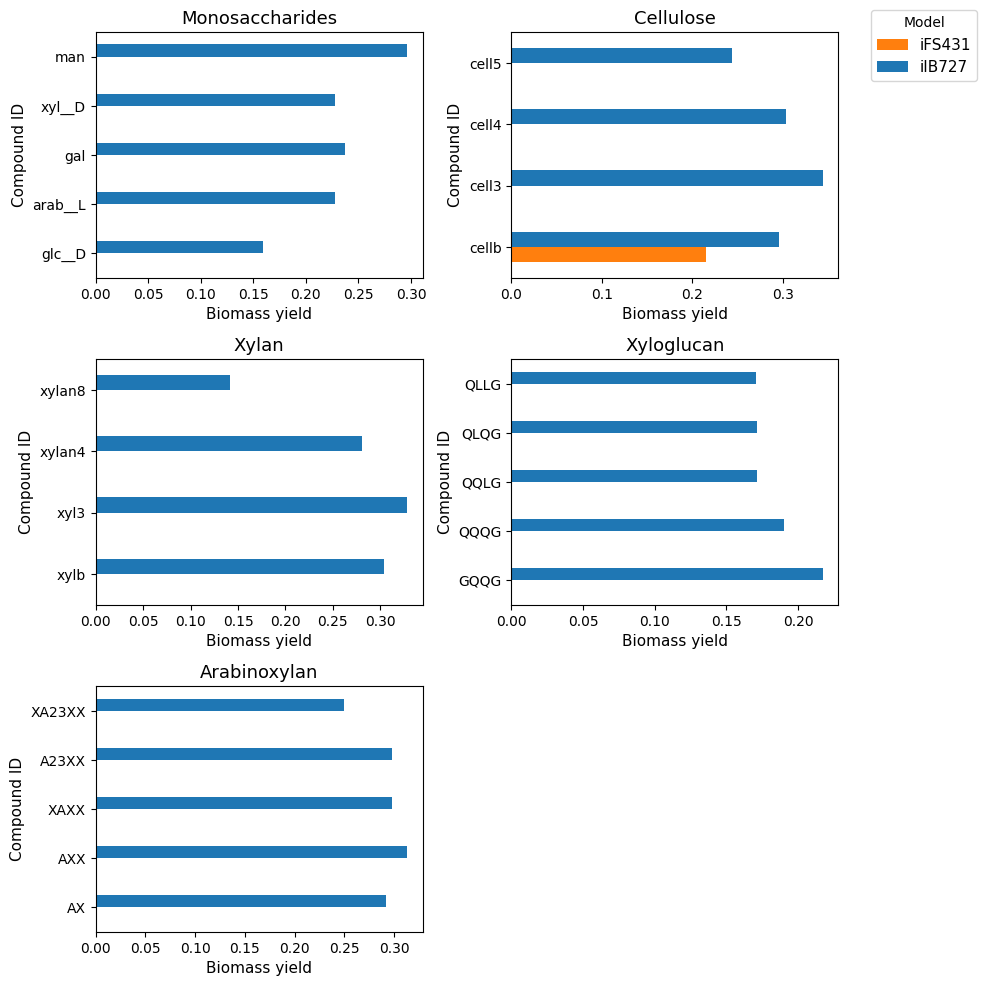

In [6]:
# Gather results
yield_iIB = pd.Series(growth)
yield_iIB.name = "iIB727"

yield_iFS = pd.Series(growth_iFS431)
yield_iFS.name = "iFS431"

yield_df  = pd.concat([yield_iFS,yield_iIB],axis=1)
yield_df = yield_df.stack().reset_index()
yield_df.columns = ["Compound group","Compound ID","Model","Biomass yield"]

fig, axs = plt.subplots(ncols=2,nrows=3,figsize=(10,10))
axs_flat = [ax for ax_sub in axs for ax in ax_sub]

compound_groups = yield_df["Compound group"].unique()
model_ids = yield_df["Model"].unique()

i = 0
for ax,compound_group in zip(axs_flat,compound_groups):
    
    yield_subdf = yield_df[yield_df["Compound group"]==compound_group].copy()
    
    # Create order for Compound ID
    compound_order = yield_subdf["Compound ID"].drop_duplicates()

    # Pivot
    wide_df = (
        yield_subdf
        .pivot(index="Compound ID", columns="Model", values="Biomass yield")
        .reindex(compound_order)  
    )
    
    if i==1:
        wide_df.plot(kind="barh",
                     ax=ax, 
                     color=["tab:orange", "tab:blue"],
                     )
    else:
        wide_df.plot(kind="barh",
             ax=ax, 
             color=["tab:orange", "tab:blue"],
             legend=None
             )

        
    ax.set_title(compound_group,fontsize=13)
    ax.set_xlabel("Biomass yield",fontsize=11)
    ax.set_ylabel("Compound ID",fontsize=11)
    
    if i==1:
        ax.legend(title="Model",loc=[1.1,0.8],fontsize=11)
    i+=1
    
axs_flat[-1].set_visible(False)
plt.tight_layout()
plt.savefig("../figures/biomass_yield.png")


## Production envelopes for various fermentation products.

In [5]:
env_cellb = Environment.from_compounds(media["DM_cellobiose"])

In [6]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values
q_ac = chemostat.iloc[2,:].values * chemostat.iloc[3,:].values / 100
q_lac = chemostat.iloc[2,:].values * chemostat.iloc[4,:].values / 100
q_etoh = chemostat.iloc[2,:].values * chemostat.iloc[5,:].values / 100

In [7]:
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')
model_draft = load_cbmodel('../models/RcH10_draft.xml', flavor='bigg')
model_iFS431 = load_cbmodel("../models/other_models/iFS431_genes.xml",exchange_detection="^EX_.*",flavor="cobra")

In [8]:
def plot_flux_envelopes(model,data,objective="R_Growth",constrained_ferm = True,iFS431_model=False,media=None):
    
    env_cellb,mu,q_cellb,q_ac,q_lac,q_etoh = data
    # predict max growth rate (secretion is constrained)
    mu_sim = []
    
    rxn_bigg_ids = ["cellb","ac","lac__L","etoh"]
    
    
    if iFS431_model:
        rxn_ids = ["EX_cellb_e_","EX_ac_e_","EX_lac_L_e_","EX_etoh_e_"]
        cpds = media["MM_cellobiose"]
        mets = [met.replace("__D","") for met in cpds]
        rxns_env = [f"EX_{met}_e_" for met in mets]
        constraints = {rxn:(-10,100) if rxn in rxns_env else (0,100) for rxn in model.get_exchange_reactions() }
    
    else:
        rxn_ids = ["R_EX_cellb_e","R_EX_ac_e","R_EX_lac__L_e","R_EX_etoh_e"]

        constraints = {}
        
    bigg2id = OrderedDict(zip(rxn_bigg_ids,rxn_ids))

    
    # Compare exp vs sim growth: Iterate through experimental data
    for i, mu_i in enumerate(mu):

        if constrained_ferm:
            constraints_new = {
                bigg2id["cellb"]:(-q_cellb[i], -q_cellb[i]),
                bigg2id["ac"]:(q_ac[i], q_ac[i]),
                bigg2id["lac__L"]:(q_lac[i], q_lac[i]),
                bigg2id["etoh"]:(q_etoh[i], q_etoh[i]),
            }
        else:
            constraints_new = {
                bigg2id["cellb"]: (-q_cellb[i], -q_cellb[i]),
            }
        constraints.update(constraints_new)
            
        sol = FBA(model, constraints=constraints,objective = {objective:1})
        mu_i = sol.fobj if sol.fobj is not None else 0
        mu_sim.append(mu_i)
    
    # BEGIN PLOT
    fig, axs = plt.subplots(2,2, figsize=(12,8), sharey=False, sharex=True)
    cmap = cm.get_cmap("gnuplot2")
    colors = cmap(np.linspace(0.25, 0.8, len(q_cellb)))
    
    # Set reactions to optimize
    if iFS431_model:
        # reset constraints
        constraints = {rxn:(-10,100) if rxn in rxns_env else (0,100) for rxn in model.get_exchange_reactions() }
        
    else:
        constraints = {}
        constraints_mu = {}
    
    exp_data = [q_ac,q_etoh,q_lac]
    prod_rxns_test = [bigg2id["ac"],bigg2id["etoh"],bigg2id["lac__L"]]
    model_copy = model.copy()

    i = 1
    
    # Compare exp vs sim production (flux envelopes): Iterate through experimental data
    for rxn, q_exp in zip(prod_rxns_test,exp_data):
        j=1 if i>1 else 0
        ax = axs[np.mod(i,2),j]

        for q_exp_i,q_cellb_i,mu_i,color_i in zip(q_exp,q_cellb,mu,colors): #,color colors
            if iFS431_model:
                constraints[bigg2id["cellb"]] = (-q_cellb_i, 0)
                constraints_mu = constraints.copy()
                constraints_mu[objective]=(0,mu_i)
            else:
                env_cellb[bigg2id["cellb"]] = (-q_cellb_i, 0)
                env_cellb.apply(model, exclusive=True, inplace=True, warning=False)
                env_cellb.apply(model_copy, exclusive=True, inplace=True, warning=False)

            model_copy.reactions[objective].ub = mu_i
            plot_flux_envelope(model_copy,objective,rxn,constraints=constraints_mu,ax=ax,steps=50,plot_kwargs={"color":color_i,"linestyle":"--"}, fill_kwargs={"color":color_i,"alpha":0.0},)
            plot_flux_envelope(model,objective,rxn,constraints=constraints,ax=ax,steps=50,plot_kwargs={"color":color_i}, fill_kwargs={"color":color_i,"alpha":0.02},)

            ax.plot([mu_i],[q_exp_i],color=color_i,marker='o',markersize=7,label=f"Cellobiose uptake={q_cellb_i}")
        met = model.reactions[rxn].get_substrates()[0]
        name = model.metabolites[met].name

        ax.set_ylim([0,8])
        ax.set_xlim([0,0.2])

        ax.set_ylabel(name + " production [mmol/($g_{CDW}$*h)]")
        ax.set_xlabel("Growth rate [1/h]")
        i +=1

    for mu_i,mu_sim_i,color_i in zip(mu,mu_sim,colors):
        axs[0,0].plot([mu_i], [mu_sim_i], 'o',markersize=7,color=color_i) 

    axs[0,0].set_ylabel('Growth rate simulated [1/h]')
    axs[0,0].set_xlabel('Growth rate experimental [1/h]')
    axs[0,0].plot(np.linspace(0,0.2,100), np.linspace(0,0.2,100),'--',color="black")
    axs[0,0].set_ylim([0,0.2])
    axs[0,0].set_xlim([0,0.2])

    axs[0,0].set_title("a)",fontsize=14,loc="left")
    axs[0,1].set_title("b)",fontsize=14,loc="left")
    axs[1,0].set_title("c)",fontsize=14,loc="left")
    axs[1,1].set_title("d)",fontsize=14,loc="left")

    axs[0,1].legend(bbox_to_anchor=(1.6, 1))#,fontsize=12)
    plt.tight_layout()

#### Curated model

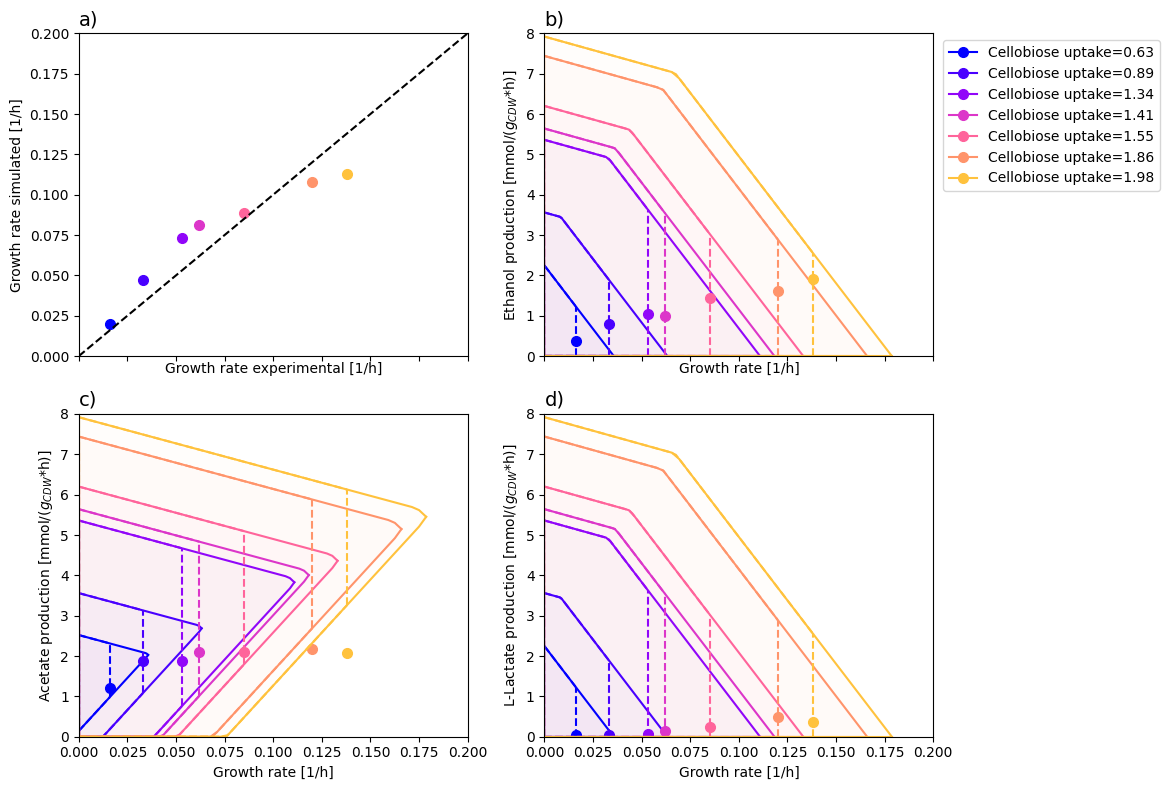

In [9]:
plot_flux_envelopes(model,[env_cellb,mu,q_cellb,q_ac,q_lac,q_etoh])
plt.savefig("../figures/flux_envelopes.png")

#### Draft model - fermentation product constraints in a)

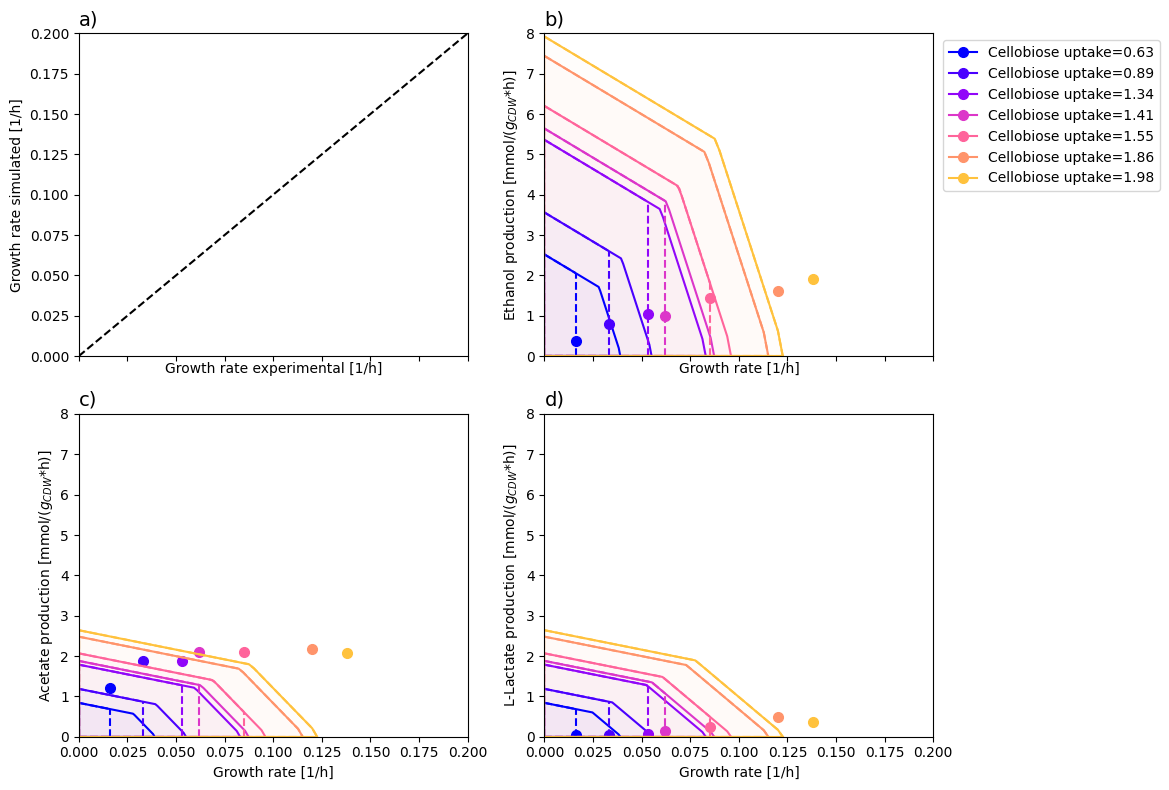

In [10]:
plot_flux_envelopes(model_draft,[env_cellb,mu,q_cellb,q_ac,q_lac,q_etoh],objective="Growth")
plt.savefig("../figures/flux_envelopes_draft.png")

#### iFS431

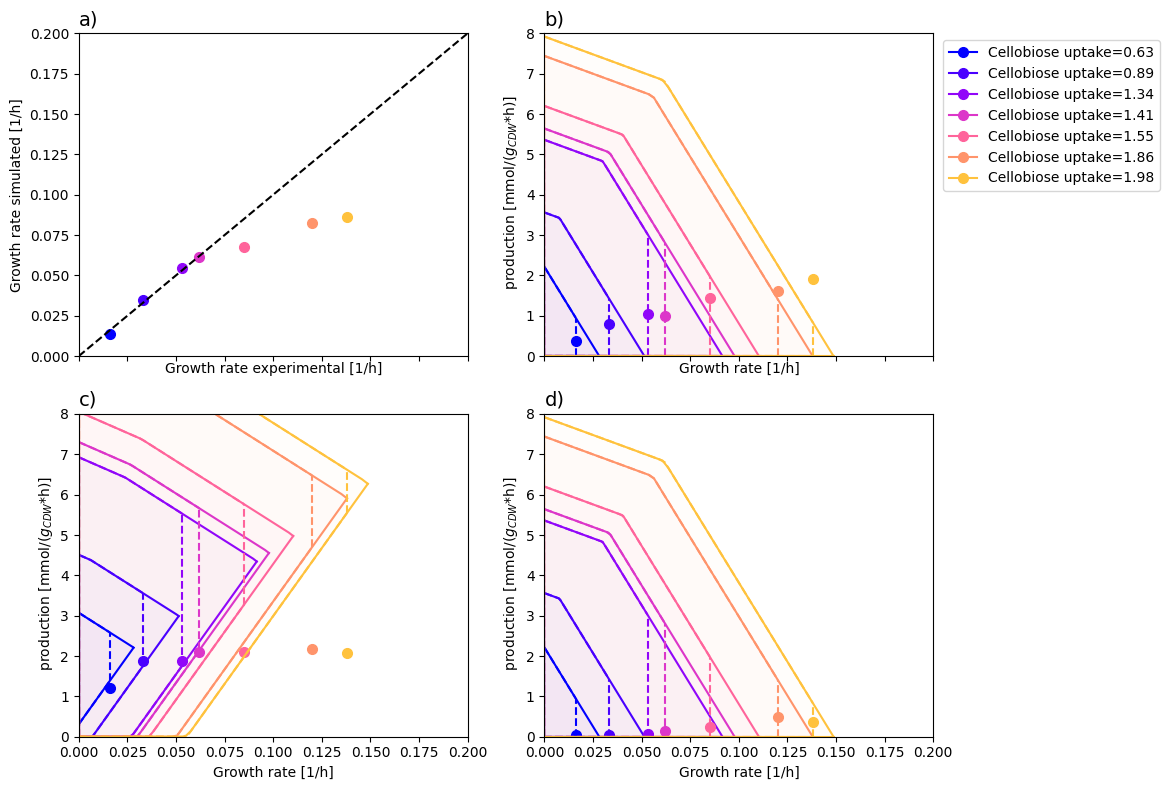

In [11]:
model_iFS431.reactions.ATPM.lb=2.2
plot_flux_envelopes(model_iFS431,
                    [env_cellb,mu,q_cellb,q_ac,q_lac,q_etoh],
                    objective="EX_BIOMASS_e_",
                    iFS431_model=True,
                    constrained_ferm=True,
                    media=media)

plt.savefig("../figures/flux_envelopes_iFS431.png")

## Gene deletion experiments 

In [12]:
sugars = {
    'Arabinose': 'arab__L',
    'Glucose': 'glc__D',
    'Cellobiose': 'cellb',
    'Galactose': 'gal',
    'Xylose': 'xyl__D',
    'Mannose': 'man',
}

genes = {
    'MTL2109': 'G_WP_015925554_1',
    'MTL3221': 'G_WP_015926569_1',
    'MTL3238': 'G_WP_015926586_1',
    'MTL3429': 'G_WP_015926769_1',
    'MTL3431': 'G_WP_015926771_1',
}

In [13]:
mutant_growth = pd.read_excel('../input/Kampik_2021_mutants.xlsx', sheet_name="gene_deletion_boolean", usecols="A:H")
mutant_growth = mutant_growth.melt(id_vars=['Mutant'], value_vars=sugars.keys(), var_name='Sugar', value_name='Experimental Growth').dropna()

In [14]:
env_init=Environment.from_compounds(media['MM_glucose'])
del env_init['R_EX_glc__D_e']
env_init.apply(model, exclusive=True, inplace=True, warning=False)
env_init.apply(model_draft, exclusive=True, inplace=True, warning=False)

In [15]:
data = []
data_draft = []
for i, row in mutant_growth.iterrows():
    
    ko = [genes[row['Mutant']]]
    constraints = {f'R_EX_{sugars[row["Sugar"]]}_e': (-10, 0)}
    sol = gene_knockout(model, ko, constraints=constraints)
    sol_draft = gene_knockout(model_draft, ko, constraints=constraints)
    
    data.append('Yes' if (sol.fobj is not None and sol.fobj > 0.001) else 'No')
    data_draft.append('Yes' if (sol_draft.fobj is not None and sol_draft.fobj > 0.001) else 'No')

mutant_growth['Predicted growth (iIB727)'] = data
mutant_growth['Predicted growth (draft model)'] = data_draft

In [16]:
mutant_growth.sort_values(['Sugar','Mutant'])

,Mutant,Sugar,Experimental Growth,Predicted growth (iIB727),Predicted growth (draft model)
1,MTL3221,Arabinose,Yes,Yes,Yes
2,MTL3238,Arabinose,Yes,Yes,Yes
3,MTL3429,Arabinose,Yes,Yes,Yes
4,MTL3431,Arabinose,Yes,Yes,Yes
10,MTL2109,Cellobiose,No,No,Yes
11,MTL3221,Cellobiose,No,No,Yes
17,MTL3238,Galactose,No,No,Yes
6,MTL3221,Glucose,No,No,Yes
26,MTL3221,Mannose,No,No,Yes
23,MTL3429,Xylose,Yes,Yes,No


### Checking for energy generating cycles

In [17]:
EGC.EGC_identifier(model)

There are NO energy producing cycles in the model


{}

### Model content

In [18]:
model.summary()

Metabolites:
C_c 749
C_p 123
C_e 181

Reactions:
enzymatic 845
transport 331
exchange 174
sink 2
other 185


In [19]:
len(model.genes)

727

In [20]:
model_draft = load_cbmodel("../models/RcH10_draft.xml")
model_draft.id = "CarveMe draft"
model.id = "iIB727"

model_iFS431 = load_cbmodel("../models/other_models/iFS431_genes.xml",load_gprs=False,flavor="cobra")
model_iFS431.id = "iFS431"

In [21]:
summary = OrderedDict()

for model_iter in [model_iFS431,model_draft,model]:
    

    print(model_iter.id)
    if model_iter.id == "iFS431":
        genes = 431
        exchange = 31
        internal = 663
        transport = 79
        
        comp_c = 679
        comp_e = 79
        summary[model_iter.id] = {"genes": {"genes":genes},
                                  "reactions":{"exchange":exchange,
                                             "internal":internal,
                                             "transport":transport},
                                  "metabolites":{"internal":comp_c,
                                                 "external":comp_e}
                                 }

    else:
        
        genes = len(model_iter.genes)
    
        exchange = len(model_iter.get_reactions_by_type(ReactionType.EXCHANGE))
        internal = len(model_iter.get_reactions_by_type(ReactionType.ENZYMATIC))
        transport = len(model_iter.get_reactions_by_type(ReactionType.TRANSPORT))
        other = len(model_iter.get_reactions_by_type(ReactionType.OTHER)) + len(model.get_reactions_by_type(ReactionType.SINK))

        comp_c = len(model_iter.get_compartment_metabolites("C_c"))
        comp_e = len(model_iter.get_compartment_metabolites("C_p"))+len(model_iter.get_compartment_metabolites("C_e"))
    
    
        summary[model_iter.id] = {"genes": {"genes":genes},
                                  "reactions":{"exchange":exchange,
                                             "internal":internal+other,
                                             "transport":transport},
                                  "metabolites":{"internal":comp_c,
                                                 "external":comp_e}
                                 }

iFS431
CarveMe draft
iIB727


In [22]:

colors = OrderedDict()
for element,values in summary["iIB727"].items():
    colors[element]={}
    for i,subcat in enumerate(values.keys()):
        if element=="genes":
            colors[element][subcat]= plt.cm.YlOrBr(0.5-i*0.2) 
        elif element=="reactions":
            colors[element][subcat]= plt.cm.Reds(0.9-i*0.2) 
        elif element=="metabolites":
            colors[element][subcat]= plt.cm.Blues(0.9-i*0.4) 

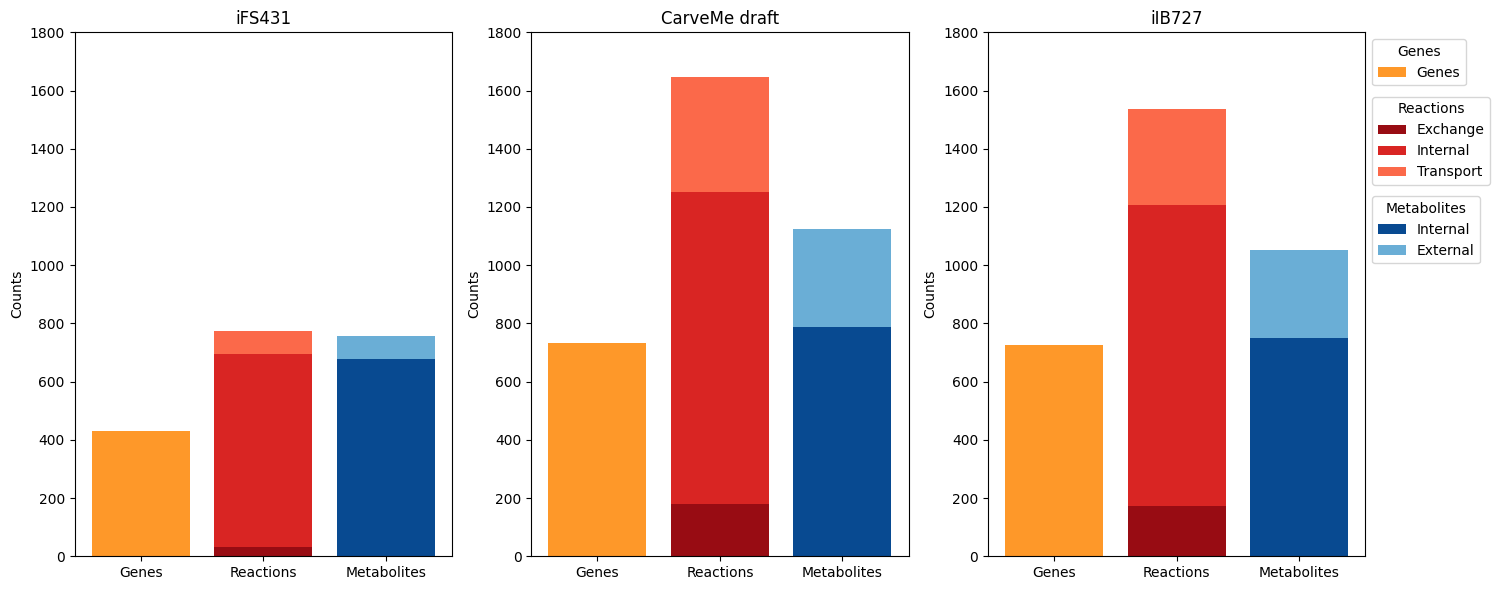

In [23]:
fig,ax = plt.subplots(1,3,figsize=(15,6))

for j,model_id in enumerate(summary.keys()):
    
    x = np.arange(len(summary[model_id].keys()))
    legends = {}
    for i, element in enumerate(summary[model_id]):
        bottom = 0 
        legends[element] = []
        for subcat,value in summary[model_id][element].items():
            plot_color = ax[j].bar(i, value, bottom=bottom,color=colors[element][subcat], label=subcat[0].capitalize() +subcat[1:])
            legends[element].append(plot_color)
            bottom += value  
    ax[j].set_xticks(x)
    
    ax[j].set_xticklabels([key[0].capitalize()+key[1:] for key in summary[model_id].keys()])
    ax[j].set_ylabel('Counts')
    ax[j].set_title(model_id)
    ax[j].set_ylim([0,1800])

first_legend =  plt.legend(handles= legends["genes"],loc="upper left",bbox_to_anchor=(1,1),title="Genes")
second_legend = plt.legend(handles= legends["reactions"],loc="upper left",bbox_to_anchor=(1,0.89),title="Reactions")
third_legend = plt.legend(handles= legends["metabolites"],loc="upper left",bbox_to_anchor=(1,0.7),title="Metabolites")

ax[2].add_artist(first_legend)
ax[2].add_artist(second_legend)
plt.tight_layout()
plt.savefig("../figures/models_summary.png", bbox_inches='tight')
plt.show()

### Comparison of ATP yield on glucose (For different mini models)

#### Load models

In [24]:
mini_model_gtp = build_mini_model(unique_cofactors=True,model_id="mini_model_gtp")
mini_model_atp = build_mini_model(unique_cofactors=False,model_id="mini_model_atp")
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')
model.reactions.R_ATPM.lb=0

In [25]:
save_cbmodel(mini_model_gtp,"../models/other_models/mini_model_gtp.xml")
save_cbmodel(mini_model_atp,"../models/other_models/mini_model_atp.xml")

model_cobra_gtp = read_sbml_model("../models/other_models/mini_model_gtp.xml")
model_cobra_atp = read_sbml_model("../models/other_models/mini_model_atp.xml")

save_json_model(model_cobra_gtp,"../models/other_models/mini_model_gtp.json")
save_json_model(model_cobra_atp,"../models/other_models/mini_model_atp.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-27


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


#### Create minimal glucose environment

In [26]:
env = Environment.from_reactions(["R_EX_h_e_","R_EX_h2o_e","R_EX_glc__D_e"])
env["R_EX_h2o_e"]=(-1000,1000)
env["R_EX_h_e"]=(-1000,1000)

rxns = ["R_EX_ac_e","R_EX_etoh_e","R_EX_lac__L_e","R_ATPM"]

#### Apply environment

In [27]:
env.apply(mini_model_atp,inplace=True,warning=False)
env.apply(mini_model_gtp,inplace=True,warning=False)
env.apply(model,inplace=True,warning=False)

### Maximizing production of different compounds

In [28]:
fba_results = {}

for model_id,model_spec in {"Mini model (GTP and PPi)":mini_model_gtp,"Mini model (ATP)":mini_model_atp,"iIB727 model":model}.items():
    
    fba_results[model_id]={}

    for rxn in rxns:
        objective = {rxn:0 for rxn in model_spec.reactions.keys()}
        objective[rxn]=1
        model_spec.set_objective(objective)
        fba_results[model_id][rxn]= FBA(model_spec,objective={rxn:1}).fobj



In [29]:
pd.DataFrame(fba_results)

,Mini model (GTP and PPi),Mini model (ATP),iIB727 model
R_EX_ac_e,20.0,20.0,20.0
R_EX_etoh_e,20.0,20.0,20.0
R_EX_lac__L_e,20.0,20.0,20.0
R_ATPM,20.0,20.0,20.0


### Prepare for and run MEMOTE tests

In [30]:
with open(f"../memote_reports/err_file_iIB727.txt",'w') as errfile:
    command = """
    source ~/opt/anaconda3/etc/profile.d/conda.sh && \
    conda activate model_testing2 && \
    memote report snapshot --filename ../memote_reports/iIB727.html ../models/iIB727.xml 
    """

    process = subprocess.Popen(command,
                               shell=True,
                               executable="/bin/bash",
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               text=True)


    while True:
        line = process.stdout.readline()
        if not line:
            break
        print(line.rstrip(), flush=True)

    
    stderr_output = process.stderr.read()
    if stderr_output:
        print("\nErrors:", stderr_output)
        errfile.write(stderr_output)

============================= test session starts ==============================
platform darwin -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/idunmariaburgos
plugins: typeguard-4.4.1, anyio-4.7.0
collected 146 items / 1 skipped

../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_annotation.py F [  0%]
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF....F.F.F.FF..F...FFF.F.FFFFFF..         [ 44%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_basic.py . [ 45%]
.....F........F.FFFFFF                                                   [ 60%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_biomass.py . [ 60%]
F.....F.F                                                                [ 67%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_consistency.py . [ 67%]
...........s.s...FFF.F.F.FFF                 

In [31]:
with open(f"../memote_reports/err_file_iIB727_draft.txt",'w') as errfile:
    command = """
    source ~/opt/anaconda3/etc/profile.d/conda.sh && \
    conda activate model_testing2 && \
    memote report diff --filename ../memote_reports/iIB727_draft.html ../models/RcH10_draft.xml ../models/iIB727.xml
    """

    process = subprocess.Popen(command,
                               shell=True,
                               executable="/bin/bash",
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               text=True)


    while True:
        line = process.stdout.readline()
        if not line:
            break
        print(line.rstrip(), flush=True)

   
    stderr_output = process.stderr.read()
    if stderr_output:
        print("\nErrors:", stderr_output)
        errfile.write(stderr_output)

============================= test session starts ==============================
platform darwin -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/idunmariaburgos
plugins: typeguard-4.4.1, anyio-4.7.0
collected 146 items / 1 skipped

../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_annotation.py . [  0%]
..============================= test session starts ==============================
platform darwin -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/idunmariaburgos
plugins: typeguard-4.4.1, anyio-4.7.0
collected 146 items / 1 skipped

../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_annotation.py FF [  0%]
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF.F.FF.F.......F.F..F.F.F..F.FF...FFF..FFF.F.FFF.F.FFFFFFFFFFF.F..         [ 44%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_basic.py . [ 45%]
.....F.      

In [32]:
with open(f"../memote_reports/err_file_iFS431.txt",'w') as errfile:
    command = """
    source ~/opt/anaconda3/etc/profile.d/conda.sh && \
    conda activate model_testing2 && \
    memote report snapshot --filename ../memote_reports/iFS431.html ../models/other_models/iFS431_genes2.xml
    """

    process = subprocess.Popen(command,
                               shell=True,
                               executable="/bin/bash",
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               text=True)


    while True:
        line = process.stdout.readline()
        if not line:
            break
        print(line.rstrip(), flush=True)

   
    stderr_output = process.stderr.read()
    if stderr_output:
        print("\nErrors:", stderr_output)
        errfile.write(stderr_output)

============================= test session starts ==============================
platform darwin -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/idunmariaburgos
plugins: typeguard-4.4.1, anyio-4.7.0
collected 146 items / 1 skipped

../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_annotation.py F [  0%]
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF..         [ 44%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_basic.py F [ 45%]
...F.FF.F...FFFFF...FF                                                   [ 60%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_biomass.py . [ 60%]
F..FFF.FF                                                                [ 67%]
../../../opt/anaconda3/envs/model_testing2/lib/python3.11/site-packages/memote/suite/tests/test_consistency.py . [ 67%]
..FFFFFFFFFFFFFFFF.FFFFF.FFF                 